###Importação de bibliotecas

In [ ]:
# Importação
import os
import pandas as pd

# Importação para usar o dataset pelo link do drive
import gdown

# Importação para extrair do zip
import zipfile

In [ ]:
# Importação para EDA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from PIL import Image
from tqdm import tqdm

import hashlib

###Crianção do dataframe

O dataset escolhido não é originalmente trabalhado como um dataframe, já que a organização primária consiste em pastas (normal vs pneumonia) com imagens. Como esse formato não é facilmente manipulável, será criado um dataframe com as informações disponíveis.

In [ ]:
# Carregando o dataset pelo link do drive criado com o dataset do kaggle
# O link do drive disponibilizado pela Ligia não foi usado por estar desatualizado
# (não ter a separação entre NORMAL e PNEUMONIA no conjunto de teste)

file_id = "1IBC3mk83DnHkZ4Xn3Kq9H18kM3_WITx2"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}",
    "/content/chest_xray.zip",
    quiet=False,
)

# Extraindo as informações
with zipfile.ZipFile("/content/chest_xray.zip", "r") as zip_ref:
    zip_ref.extractall("/content/data_chest_xray")

print("Dataset carregado!")

Downloading...
From (original): https://drive.google.com/uc?id=1IBC3mk83DnHkZ4Xn3Kq9H18kM3_WITx2
From (redirected): https://drive.google.com/uc?id=1IBC3mk83DnHkZ4Xn3Kq9H18kM3_WITx2&confirm=t&uuid=a84b6ccf-b79c-422c-9504-0624c24e6046
To: /content/chest_xray.zip
100%|██████████| 1.26G/1.26G [00:16<00:00, 76.7MB/s]


Dataset carregado!


In [ ]:
# Criação do dataframe
# Como há dois casos: uma pasta de treino (subdividida em NORMAL e PNEUMONIA)
# e uma pasta de teste não subdividida nem rotulada,
# é feita a seguinte divisão

In [ ]:
# Função de criação de dataframe
def create_df(rows, path):
    for label in ["NORMAL", "PNEUMONIA"]:
        folder = os.path.join(path, label)

        if not os.path.exists(folder):
            continue

        for filename in os.listdir(folder):
            if filename.lower().endswith((".jpeg", ".jpg", ".png")):
                rows.append({
                    "filepath": os.path.join(folder, filename),
                    "filename": filename,
                    "label": label,
                    "label_bin": 0 if label == "NORMAL" else 1,
                    })

    df = pd.DataFrame(rows)
    return df

In [ ]:
# Criação do dataframe de treino
rows_train = []
train_path = "/content/data_chest_xray/chest_xray/train"

df_train = create_df(rows_train, train_path)
print(f"Treino: {len(df_train)} imagens")
print(df_train["label"].value_counts())

Treino: 5232 imagens
label
PNEUMONIA    3883
NORMAL       1349
Name: count, dtype: int64


Com os dados obtidos até agora é possível identificar 2 pontos interessantes:
1. O dataset dividido em treino e teste não possui a convencional separação de 70% por 30%, sendo mais próxima de 90% por 10%. Isso reforça a ideia de estabelecer um subconjunto de validação em cima do conjunto de treino.
2. As classes apresentadas são bem desbalanceadas no conjunto de treino, com a quantidade de imagens de casos com pneumonia sendo quase 3x maior do que a quantidade de casos normais. (Isso será demonstrado melhor posteriormente).

Apenas o df_treino será considerado na EDA.

###Distribuição de classes

In [ ]:
# Diagnóstico de balanceamento
xray_counts = df_train['label'].value_counts()
xray_percent = xray_counts / len(df_train) * 100

ratio = xray_counts.max() / xray_counts.min()
print(f'Razão desbalanceamento: {ratio:.2f}x')
if ratio > 1.5:
    print('Dataset desbalanceado!')
else:
    print('Dataset razoavelmente balanceado.')

Razão desbalanceamento: 2.88x
Dataset desbalanceado!


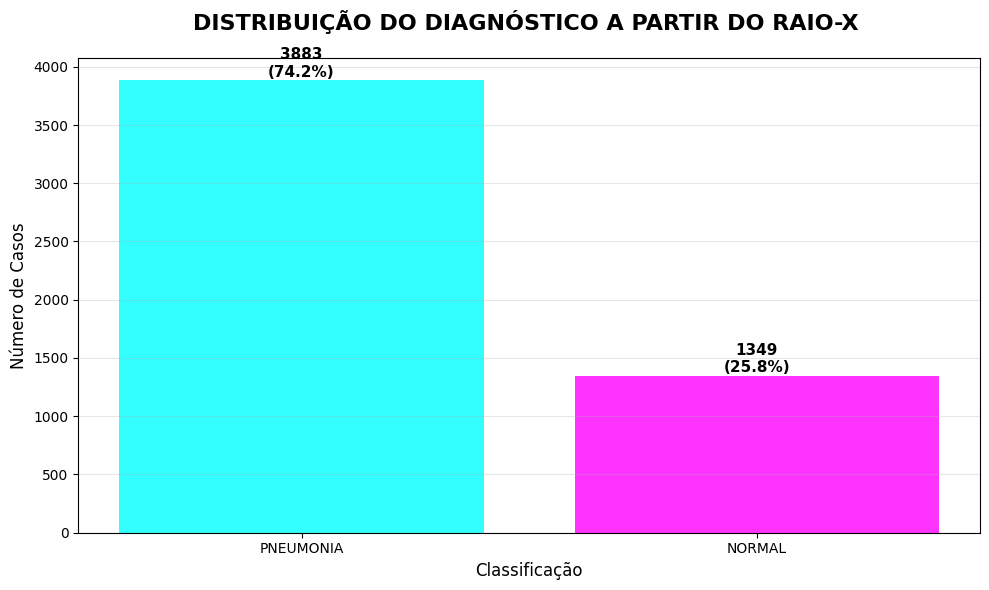

In [ ]:
# Distribuição do diagnóstico a partir do raio-X (NORMAL vs PNEUMONIA)
# Gráfico em colunas e razão percentual
plt.figure(figsize=(10, 6))

colors = ['cyan', 'magenta',]

bars = plt.bar(
    xray_counts.index,
    xray_counts.values,
    color=colors,
    alpha=0.8,
    )

plt.title(
    'DISTRIBUIÇÃO DO DIAGNÓSTICO A PARTIR DO RAIO-X ',
    fontsize=16,
    fontweight='bold',
    pad=20,
    )

plt.xlabel('Classificação', fontsize=12)
plt.ylabel('Número de Casos', fontsize=12)

for bar, count, percent in zip(
    bars,
    xray_counts.values,
    xray_percent.values,
    ):
    height = bar.get_height()

    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 5,
        f'{count}\n({percent:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold',
        )

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Inicialmente é visível o **desbalanceamento de classes**, sendo que a classe PNEUMONIA tem 2.88 vezes mais casos de referência do que a classe NORMAL. Como a diferença de quantidade é considerável, deverá ser aplicado método de balanceamento de classes (ex.: *SMOTE*, *OverSampling*). Vale ressaltar que não é interessante usar o *UnderSampling*, já que muitos casos de referência de pneumonia seriam perdidos, comprometendo a qualidade de treinamento do modelo.



###Presença de elementos distratores

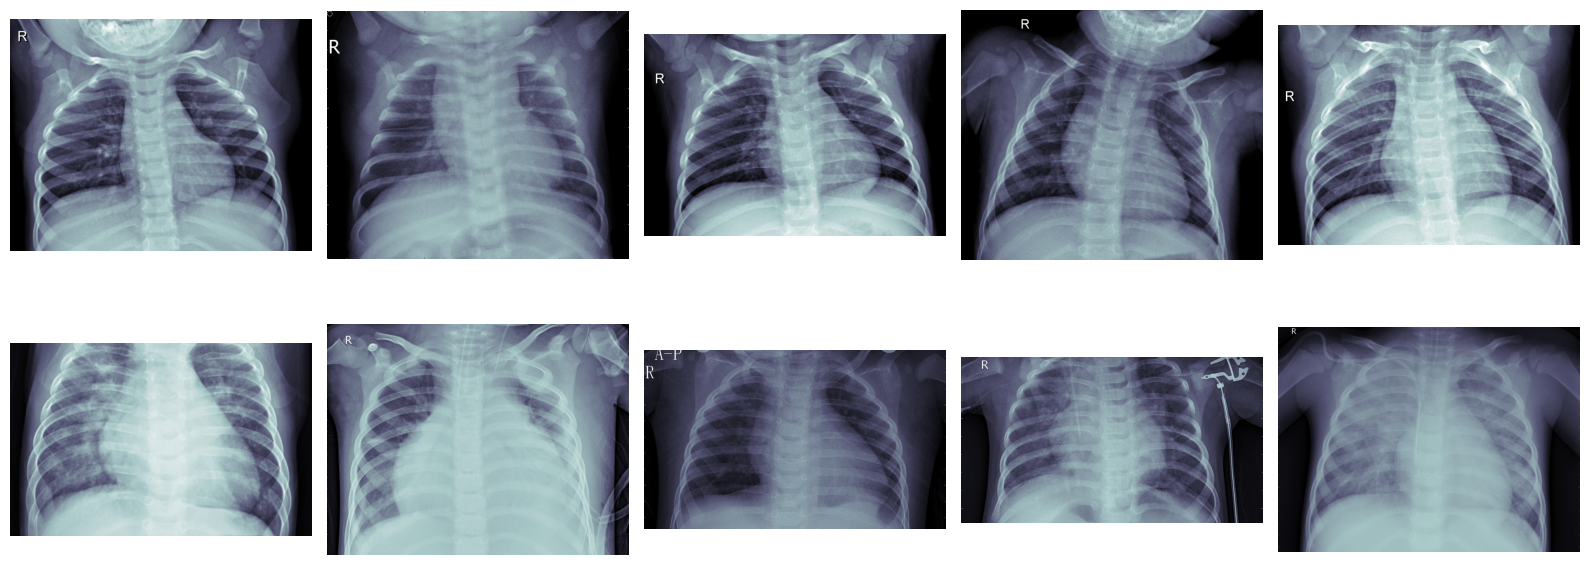

In [ ]:
# Amostragem de cada classe
fig, axes = plt.subplots(2, 5, figsize=(16, 7))

for row_idx, label in enumerate(['NORMAL', 'PNEUMONIA']):
    samples = df_train[df_train['label'] == label].sample(5, random_state=42)
    for col_idx, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row['filepath']).convert('L')
        axes[row_idx, col_idx].imshow(img, cmap='bone')
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

A primeira linha é de casos normais e a segunda é de casos com pneumonia. Ao observar essas amostras, é possível inferir que:
1. As imagens são de tamanhos diferentes, não são padronizadas. Isso implica na necessidade de usar uma ferramenta para transformar todas em imagens de mesma dimensão sem "achatar" nem perder informações. (Será tratado posteriormente)
2. É necessário abstrair informações não relevantes para a classificação das imagens, como, por exemplo, a posição dos braços dos pacientes. Todas as imagens normais apresentam o paciente com os braços erguidos, enquanto 4/5 imagens com pneumonia têm o paciente com os braços na horizontal/abaixados. Isso pode ser apenas uma coincidência da amostragem, mas pode levar ao enviesamento do modelo.
3. Nessas amostras, há 2 casos com pneumonia (imagens 2 e 4) que têm elementos externos, que também podem tendenciar o modelo a classificar como pneumonia.
4. Há diferença no brilho do raio-x, algumas imagens estão mais apagadas enquanto há outras com brilho quase ofuscante, o que também deve ser tratado.
5. Também há imagens cinza e outras azuladas, o que dificulta a generalização do modelo, sendo necessário a conversão das imagens em RGB para a escala L (cinza). Essa escolha é feita para diminuir o custo computacional (1 matriz é analisada ao invés de 3) e para abstração de informação, já que as cores não são relevantes para a classificação nesse caso.
6. Além disso, as imagens têm diferentes níveis de inclinação do paciente, logo o modelo deve ser treinado para fazer o reconhecimento em diferentes ângulos.

*Nem todas as observações feitas aqui serão relevantes para o produto final, mas devem ser ressaltadas como parte do processo de análise.

###Geração de imagem média

In [ ]:
# Função que cria uma imagem média a partir da média dos pixels em cada classe
def mean_image(df, label_target, tamanho=(224, 224)):
    df_filtrado = df[df['label'] == label_target]

    add_pixels = np.zeros(tamanho, dtype=np.float64)
    count = 0

    print(f"Processando classe: {label_target}...")

    for filepath in tqdm(df_filtrado['filepath']):
        try:
            with Image.open(filepath) as img:
                img = img.convert('L')
                img = img.resize(tamanho)
                img_array = np.array(img, dtype=np.float64)

                add_pixels += img_array
                count += 1
        except Exception as e:
            print(f"Erro ao ler {filepath}: {e}")

    if count > 0:
        media_pixels = add_pixels / count
    else:
        return None

    return media_pixels

Processando classe: NORMAL...


100%|██████████| 1349/1349 [00:39<00:00, 34.55it/s]


Processando classe: PNEUMONIA...


100%|██████████| 3883/3883 [00:39<00:00, 98.70it/s]


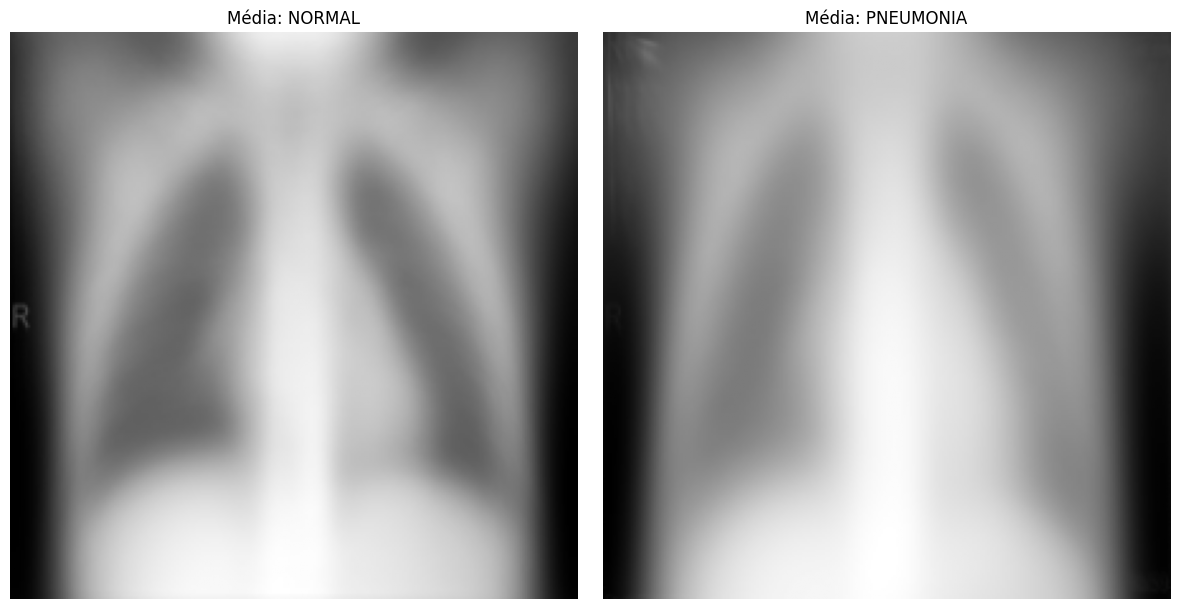

In [ ]:
# Geração das imagens
mean_normal = mean_image(df_train, 'NORMAL')
mean_pneumo = mean_image(df_train, 'PNEUMONIA')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(mean_normal, cmap='gray')
plt.title("Média: NORMAL")
plt.axis('off')

# Plot Imagem Média - PNEUMONIA
plt.subplot(1, 2, 2)
plt.imshow(mean_pneumo, cmap='gray')
plt.title("Média: PNEUMONIA")
plt.axis('off')

plt.tight_layout()
plt.show()

A partir da geração da imagem média, é possível identificar certa semelhança entre ambas as imagens, sendo que a imagem com pneumonia é mais esbranquiçada no centro dos pulmões (indicando a presença de flúidos). Isso revela que o principal fator de classificação deve ser o esbranquecimento dessa região central, como o esperado.
O mais preocupante é a presença do R na imagem média normal, essa marcação pode acabar enviesando o modelo a aceitar imagens com R como normais, quando não são. Além disso, as imagens são consideramente borradas, o que indica a despadronização da tirada das fotos (inclinadas ou cortadas).

###Geração do heatmap

In [ ]:
# Estrutura para gerar o heatmap
target_size = (224, 224)

def load_and_resize(path):
    img = Image.open(path).convert("L")
    img = img.resize(target_size)
    return np.array(img)

normal_imgs = []
pneumo_imgs = []

for _, row in df_train.iterrows():
    img_array = load_and_resize(row["filepath"])

    if row["label"] == 'NORMAL':
        normal_imgs.append(img_array)
    else:
        pneumo_imgs.append(img_array)

normal_stack = np.stack(normal_imgs)
pneumonia_stack = np.stack(pneumo_imgs)

mean_normal = np.mean(normal_stack, axis=0)
mean_pneumonia = np.mean(pneumonia_stack, axis=0)

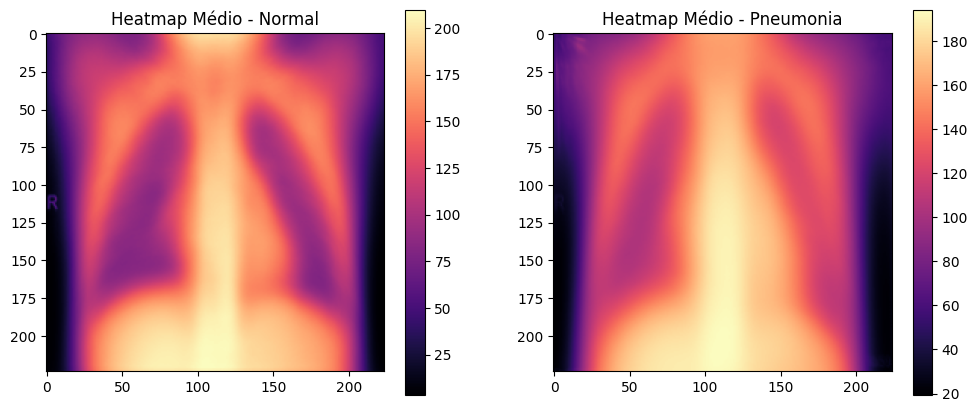

In [ ]:
# Plot do heatmap
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(mean_normal, cmap="magma")
plt.title("Heatmap Médio - Normal")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(mean_pneumonia, cmap="magma")
plt.title("Heatmap Médio - Pneumonia")
plt.colorbar()

plt.show()

A observação do heatmap, após a imagem média, permite confirmar que a maior diferença entre as classes é a diferença de densidade na área dos pulmões, que ficam mais apagados em casos de pneumonia. Além disso, confirma que os casos normais são frequentemente associados a marcações com R.

###Tamanho das imagens

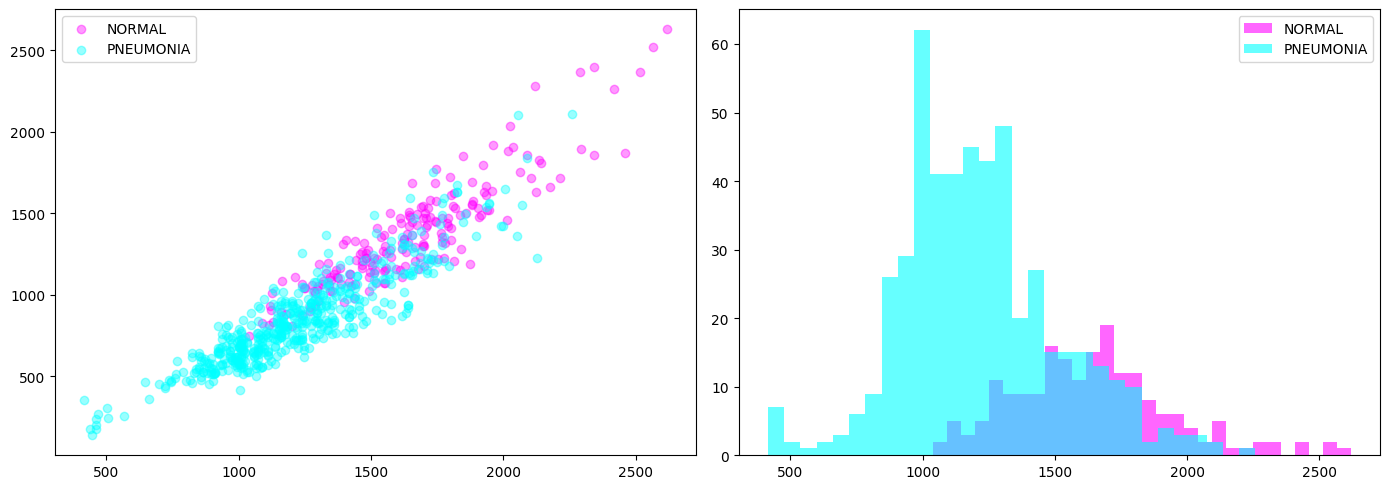

In [ ]:
# Comparação do tamanho das imagens
# Como o dataset tem mais de 5000 imagens,
# a coleta de informação se torna desnecessariamente longa,
# então uma amostra será usada nesta etapa
widths, heights = [], []

sample_df = df_train.sample(700, random_state=42)

for _, row in sample_df.iterrows():
    img = Image.open(row['filepath'])
    widths.append(img.width)
    heights.append(img.height)

sample_df['width'] = widths
sample_df['height'] = heights
sample_df["resolution"] = sample_df["width"] * sample_df["height"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for label, color in [('NORMAL', 'magenta'), ('PNEUMONIA', 'cyan')]:
    subset = sample_df[sample_df['label'] == label]
    axes[0].scatter(
        subset['width'],
        subset['height'],
        alpha=0.4,
        color=color,
        label=label,
        )

    axes[1].hist(
        subset['width'],
        bins=30,
        alpha=0.6,
        color=color,
        label=label,
        )

axes[0].legend()
axes[1].legend()
plt.tight_layout()
plt.show()

O primeiro gráfico é de dispersão (largura x altura) e o segundo indica quantas imagens há em cada faixa de valor de tamanho.
1. O primeiro gráfico mostra que a maioria dos casos de pneumonia é identificada em imagens relativamente pequenas, enquanto casos normais apresentam-se em imagens maiores. Isso é um problema, pois o modelo pode associar que a doença está ligada ao quão pequena a imagem é, além de dificultar a análise correta em cada caso. Ademais, as imagens tendem a ser quadradas (ocupam a diagonal crescente do gráfico), facilitando a interpretação de dados.
2. O segundo gráfico deixa perceptível o quão destoante é a quantidade de cada classe, além de ressaltar que casos de pneumonia são mais frequentes em imagens pequenas.

Essa análise torna necessária a conversão do tamanho da entrada para um tamanho padrão.


###Brilho médio das imagens

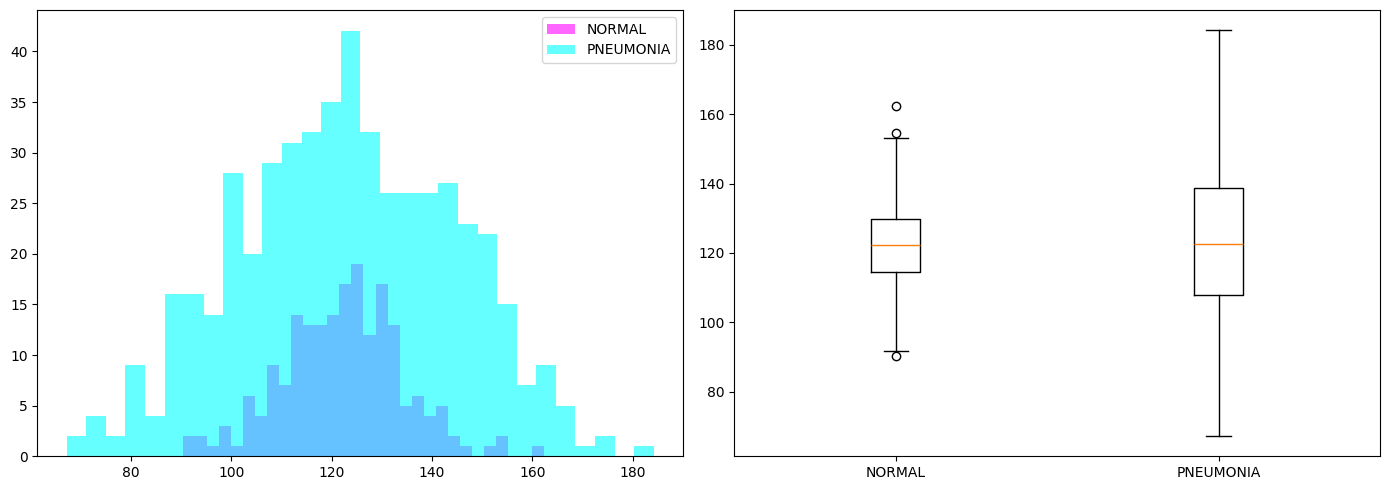

In [ ]:
# Comparação da distribuição de brilho médio
# O esperado é que o brilho seja maior nos casos de pneumonia,
# devido às propriedades da doença de retenção de líquido
# A estratégia de amostragem também será utilizada aqui
mean_pixels = []

for _, row in sample_df.iterrows():
    img = Image.open(row['filepath']).convert('L').resize((128, 128))
    arr = np.array(img)
    mean_pixels.append(arr.mean())

sample_df['mean_pixel'] = mean_pixels

normal = sample_df[sample_df['label'] == 'NORMAL']
pneumonia = sample_df[sample_df['label'] == 'PNEUMONIA']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(
    normal['mean_pixel'],
    bins=30,
    alpha=0.6,
    color='magenta',
    label='NORMAL',
    )

axes[0].hist(
    pneumonia['mean_pixel'],
    bins=30,
    alpha=0.6,
    color='cyan',
    label='PNEUMONIA',
    )

axes[0].legend()

axes[1].boxplot(
    [normal['mean_pixel'].values, pneumonia['mean_pixel'].values],
    tick_labels=['NORMAL', 'PNEUMONIA'],
    )

plt.tight_layout()
plt.show()

Os gráficos revelam que a distribuição média de brilho é parecida, ou seja, o brilho médio das imagens, que se apresenta em faixas, está sobreposto. Fora isso, o boxplot confirma que a faixa de valores é parecida, sendo que a variação dos casos de pneumonia é maior, pois há mais dados. Portanto, o brilho da imagem não é um bom fator de classificação neste caso. Mesmo assim, é importante que o brilho seja corrigido para um bom desempenho do modelo, sendo uma forma de suavizar outliers também.

###Outras análises

In [ ]:
# Verificando se há alguma imagem na escala RGB
qtd_rgb, qtd_l = 0, 0

for filepath in df_train['filepath']:
    with Image.open(filepath) as img:
        if img.mode == 'RGB':
            qtd_rgb += 1
        elif img.mode == 'L':
            qtd_l += 1

print(f"Imagens RGB: {qtd_rgb}")
print(f"Imagens Grayscale (L): {qtd_l}")

Imagens RGB: 283
Imagens Grayscale (L): 4949


Isso revela que há imagens na escala RGB, embora a maioria esteja na Grayscale. É importante que todas as imagens sejam convertidas para a escala L para: diminuir o trabalho computacional, evitar que as imagens coloridas sejam tendenciosas em relação a alguma classe.

In [ ]:
# Checa se há duplicadas no dataset
def calcular_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df_train['hash'] = df_train['filepath'].apply(calcular_hash)

duplicatas = df_train[df_train.duplicated(subset='hash', keep='first')]
print(f"Duplicatas encontradas: {len(duplicatas)}")

Duplicatas encontradas: 26


Isso indica que há duplicatas. A eliminação desses casos é favorável para que haja um treinamento mais claro.

In [ ]:
# Checa se há imagens corrompidas no dataset
corrompidas = []

for _, row in df_train.iterrows():
    try:
        img = Image.open(row['filepath'])
        img.verify()
    except Exception as e:
        corrompidas.append(row['filepath'])

print(f"Imagens corrompidas: {len(corrompidas)}")

Imagens corrompidas: 0


Como o dataset é público, de uma fonte externa, é relevante analisar. Felizmente, todas as imagens são utilizáveis.

###Conclusão

O dataset diferencia dois tipos de pneumonia: a viral e a bacteriana, sendo que essa distinção não é interessante no contexto do desafio, então foi desconsiderada.

A partir das etapas de análise conduzidas aqui, é possível resumir que:
1. As classes são desbalanceadas, com a maioria das imagens sendo classificadas como PNEUMONIA, destacando a necessidade de aplicar técnicas como SMOTE ou OverSampling.
2. Há elementos distratores que podem prejudicar o aprendizado correto do modelo, o que deve ser abstraído, principalmente a sinalização "R", associdada aos casos normais.
3. As imagens médias e os heatmaps gerados confirmam que o principal fator de classificação é o esbranquiçado/maior densidade na área dos pulmões em relação a casos normais.
4. As imagens são de tamanhos variados, sendo que as de pneumonia tendem a ser menores do que as normais. É necessário aplicar técnicas de redimensionamento.
5. O briho médio das imagens é parecido, embora existem outliers.
6. A maioria das imagens é na escala de cinza L, mas há muitas no padrão RGB. Por convenicência, todas devem ser convertidas para o padrão L.
7. Há 26 duplicatas e nenhuma imagem está corrompida.